In [1]:
import numpy as np
from pycbf import CPUCoherenceBeamformer
from pycbf import CPUBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import timuscle.dataio as dio
from scipy.signal import hilbert, coherence
import os

from tqdm.notebook import tqdm

from time import time

In [2]:
from timuscle.autoprocessing.__rf_preproc__ import __GE9LD_SORT__ as reorg

In [3]:
reorg

array([119, 120, 115, 121, 114, 122, 113, 123, 112, 124, 118, 125, 117,
       126, 116, 127, 180, 191, 181, 190, 182, 189, 183, 188, 164, 187,
       165, 186, 166, 185, 171, 184,  32,  43,  33,  42,  34,  41,  35,
        40,  36,  47,  37,  46,  38,  45,  39,  44, 240, 244, 241, 245,
       242, 246, 243, 247, 227, 228, 226, 229, 225, 230, 224, 231,  48,
        56,  50,  57,  52,  58,  54,  60,  49,  62,  51,  59,  53,  61,
        55,  63, 235, 239, 234, 238, 233, 237, 232, 236, 251, 255, 250,
       254, 249, 253, 248, 252,   7,  11,   6,  10,   5,   9,   4,   8,
         3,  15,   2,  14,   1,  13,   0,  12, 204, 196, 205, 197, 192,
       198, 193, 199, 194, 208, 195, 209, 206, 210, 207, 211,  16,  27,
        17,  26,  18,  25,  19,  24,  20,  31,  21,  30,  22,  29,  23,
        28, 215, 223, 214, 222, 213, 221, 212, 220, 203, 216, 202, 217,
       201, 218, 200, 219,  82,  83,  81,  84,  80,  85,  79,  86,  67,
        68,  66,  69,  65,  70,  64,  71, 144, 151, 145, 150, 14

In [4]:
path = "/home/wew12/data/invivo/RawData/"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230512_P003_v2/acq_06_flex_42_pushfocus_25mm/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230519_P006/acq_05_kf_43_vl_L/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_2_flex_45_musc_vl/RawData"
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250423_exvivo_porkchop/exvivo_warm/SSI_radius_1.00/acq_001/RawData"
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250423_exvivo_porkchop/exvivo_warm/SSI_radius_1.00/acq_002/RawData"
path = "/fastrs/ultrasound/TIMuscle/ExVivo/20250429_embedded_test/beef_rswei/SSI_radius_1000.00/acq_001/RawData"
path = "/fastrs/ultrasound/TIMuscle/Phantoms/20250430_apod_test/acq_002_default/RawData"

rf, dims, params = dio.verasonics_loadbmoderf(path)

allfiles = os.listdir(path)
allfiles.sort()

# find the tracking RF data
fname = allfiles[-2][:-4]

print(rf.shape)

if params['trans']['Trans']['name'] == "GE9LD":
    loadpath = os.path.join(path, fname+".bin")
    rfraw = np.memmap(loadpath, dtype=np.int16).reshape(256, -1)[reorg,:int(np.prod(rf.shape[1:]))]
    rf = rfraw.reshape(rf.shape)

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

(192, 1, 11, 1664)


In [5]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.mean(cross / (sig[:n-lag] * sig[lag:]))

In [12]:
sospeak = 1540

dsfx = 2
dsfz = 2*dsfx

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = 0.66,
    lam = lam,
    xmin = -30E-3,
    xmax = 30E-3,
    zmin = 1E-3,
    zmax = 80E-3
)

dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    ctx=c,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=0.66
)

apodrx[9] = 0
apodrx[19] = 0
apodrx[39] = 0
apodrx[171] = 0

apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

  0%|          | 0/308 [00:00<?, ?it/s]

/tmp/ipykernel_857855/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


{'kind': 'cubic'} make beamformer: 282.37 ms, beamform: 42283.53 ms, calc coherence: 99073.11 ms


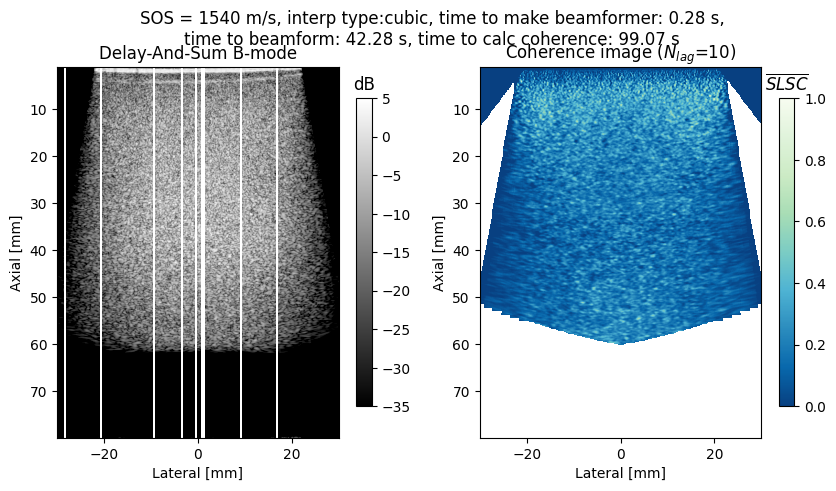

  0%|          | 0/308 [00:00<?, ?it/s]

{'kind': 'nearest', 'usf': 8} make beamformer: 292.17 ms, beamform: 17431.97 ms, calc coherence: 99997.06 ms


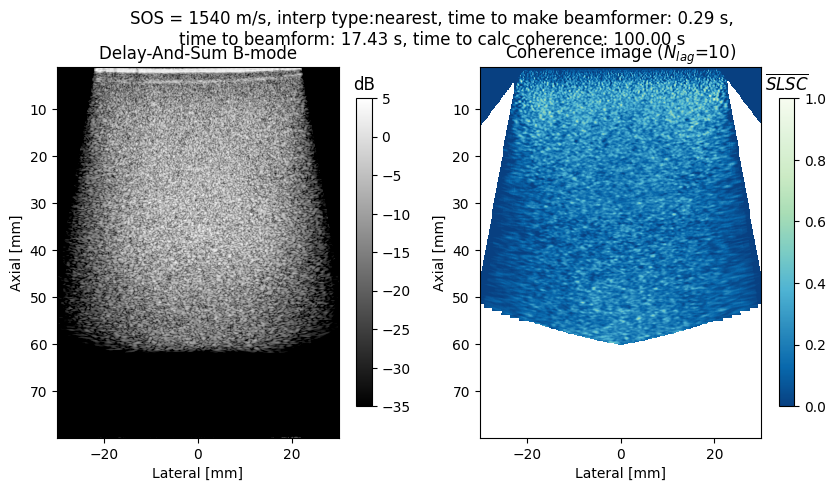

In [15]:
interps = [dict(kind='cubic'), dict(kind='nearest',usf=1), dict(kind='nearest',usf=2), dict(kind='nearest',usf=4), dict(kind='nearest',usf=8), dict(kind='nearest',usf=16)]
interps = [dict(kind='cubic'), dict(kind='nearest',usf=8)]
# interps = [dict(kind='nearest',usf=8)]

nlag = 10
subset = np.ascontiguousarray(rf[:,0,:,:].transpose(1, 0, 2))
for interp in interps:

    t1 = time()
    bmfrm = CPUCoherenceBeamformer(
        tautx=tautx,
        taurx=taurx,
        apodtx=apodtx,
        apodrx=apodrx,
        t0 = t[0],
        dt = t[1]-t[0],
        nt = len(t),
        nwrkr=1,
        interp=interp
    )
    t2 = time()
    im = bmfrm(subset).reshape(-1,len(xout), len(zout))
    t3 = time()
    locpeak = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
    for ix in tqdm(range(0, xout.size, dsfx), leave=False):
        for iz in range(0, zout.size, dsfz):
            izmin = np.max([0, iz-nkern])
            izmax = np.min([zout.size, iz+nkern+1])

            mask = apodrx_coherence[:,ix,izmin:izmax]
            elesel = np.sum(mask, axis=-1) == mask.shape[-1]

            if np.sum(elesel) < nlag+1: continue

            channels = im[elesel,ix,izmin:izmax]

            for lag in np.arange(1, nlag+1, dtype=int):
                locpeak[ix//dsfx,iz//dsfz] += calc_lagn_coherence(channels.T, lag)/nlag
    t4 = time()

    description = f"SOS = {sospeak:0.00f} m/s, interp type:{interp['kind']}, time to make beamformer: {(t2-t1):0.02f} s,\ntime to beamform: {(t3-t2):0.02f} s, time to calc coherence: {(t4-t3):0.02f} s"
    print(interp, f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(t3-t2):0.02f} ms, calc coherence: {1000*(t4-t3):0.02f} ms")

    ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    ax = axes[1]
    pltim = ax.imshow(locpeak.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
    ax.set_ylabel("Axial [mm]")
    ax.set_xlabel("Lateral [mm]")
    ax.set_title(f"Coherence image ($N_{{lag}}$={nlag})")
    plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("$\\overline{SLSC}$")

    env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
    logged = 20 * np.log10(env/np.nanpercentile(env, 99))

    ax = axes[0]
    pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
    ax.set_ylabel("Axial [mm]")
    ax.set_xlabel("Lateral [mm]")
    ax.set_title("Delay-And-Sum B-mode")
    plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
    fig.suptitle(description)
    plt.show()

    del bmfrm

  0%|          | 0/308 [00:00<?, ?it/s]

/tmp/ipykernel_857855/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


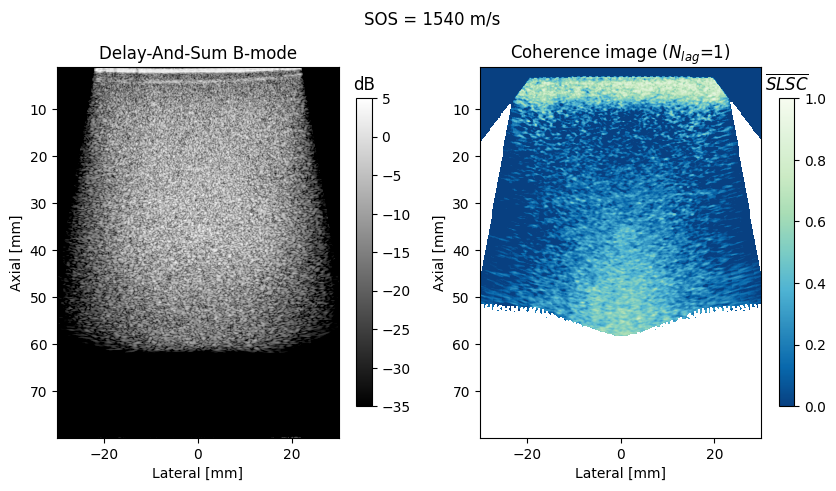

{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


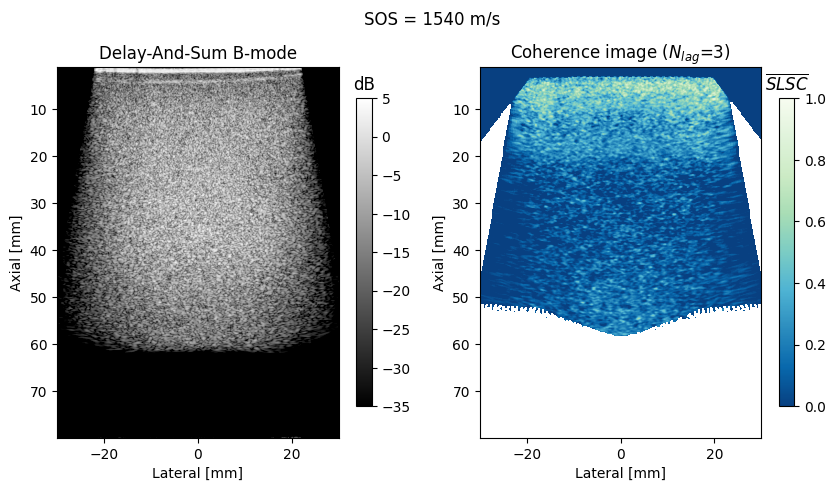

{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


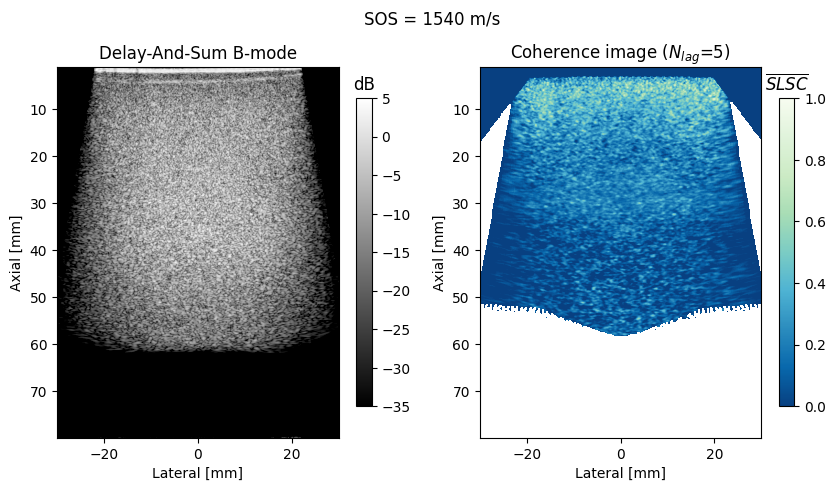

{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


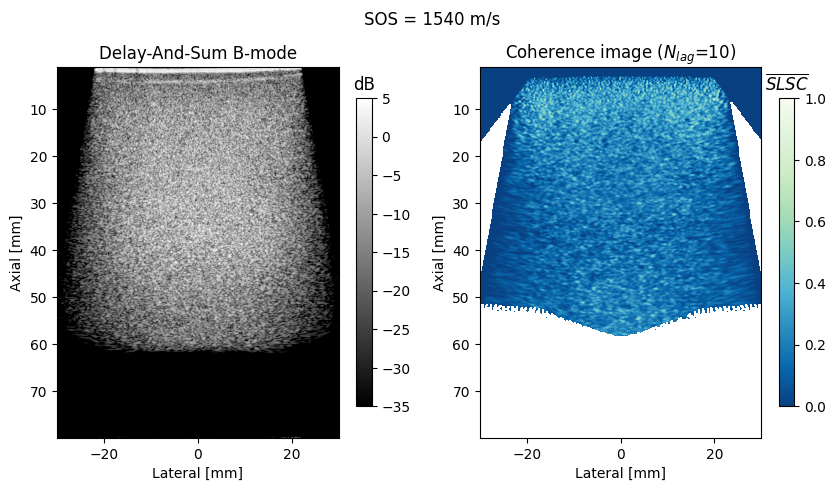

{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


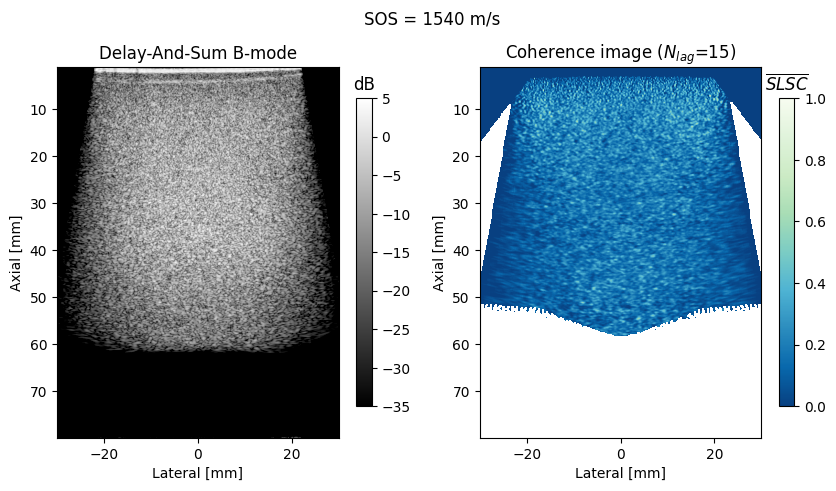

{'kind': 'nearest', 'usf': 8} make beamformer: 285.62 ms, beamform: 17553.30 ms, calc coherence: 182722.32 ms


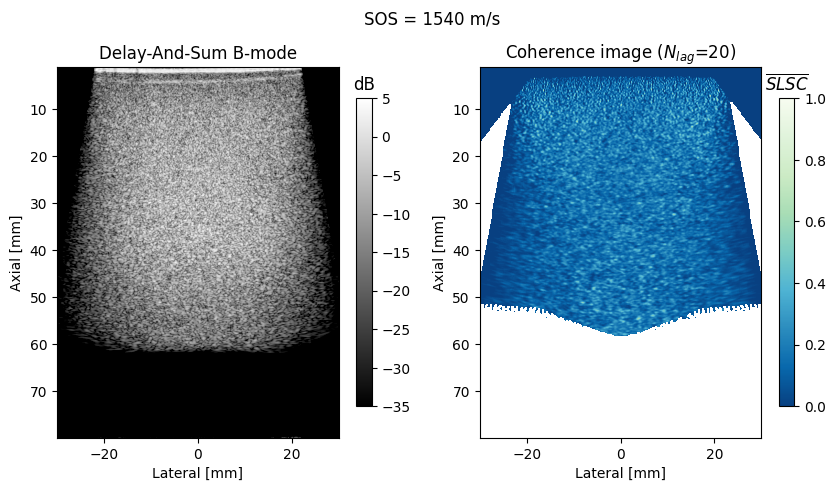

In [20]:
interps = [dict(kind='cubic'), dict(kind='nearest',usf=1), dict(kind='nearest',usf=2), dict(kind='nearest',usf=4), dict(kind='nearest',usf=8), dict(kind='nearest',usf=16)]

interps = [dict(kind='nearest',usf=8)]

subset = np.ascontiguousarray(rf[:,0,:,:].transpose(1, 0, 2))

for interp in interps:
    for nlag in [20]:
        t1 = time()
        bmfrm = CPUCoherenceBeamformer(
            tautx=tautx,
            taurx=taurx,
            apodtx=apodtx,
            apodrx=apodrx,
            t0 = t[0],
            dt = t[1]-t[0],
            nt = len(t),
            nwrkr=1,
            interp=interp
        )
        t2 = time()
        im = bmfrm(subset).reshape(-1,len(xout), len(zout))
        t3 = time()
        locpeak = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz, nlag))
        for ix in tqdm(range(0, xout.size, dsfx), leave=False):
            for iz in range(0, zout.size, dsfz):
                izmin = np.max([0, iz-nkern])
                izmax = np.min([zout.size, iz+nkern+1])

                mask = apodrx_coherence[:,ix,izmin:izmax]
                elesel = np.sum(mask, axis=-1) == mask.shape[-1]

                if np.sum(elesel) < nlag+1: continue

                channels = im[elesel,ix,izmin:izmax]

                for ilag, lag in enumerate(np.arange(1, nlag+1, dtype=int)):
                    locpeak[ix//dsfx,iz//dsfz, ilag] = calc_lagn_coherence(channels.T, lag)
        t4 = time()
        del bmfrm

    for nlag in [1, 3, 5, 10, 15, 20]:
        description = f"SOS = {sospeak:0.00f} m/s"
        print(interp, f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(t3-t2):0.02f} ms, calc coherence: {1000*(t4-t3):0.02f} ms")

        ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        ax = axes[1]
        pltim = ax.imshow(np.mean(locpeak[:,:,:nlag], axis=-1).T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
        ax.set_ylabel("Axial [mm]")
        ax.set_xlabel("Lateral [mm]")
        ax.set_title(f"Coherence image ($N_{{lag}}$={nlag})")
        plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("$\\overline{SLSC}$")

        env = np.abs(hilbert(np.nansum(im, axis=0), axis=-1)).T
        logged = 20 * np.log10(env/np.nanpercentile(env, 99))

        ax = axes[0]
        pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
        ax.set_ylabel("Axial [mm]")
        ax.set_xlabel("Lateral [mm]")
        ax.set_title("Delay-And-Sum B-mode")
        plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
        fig.suptitle(description)
        plt.show()

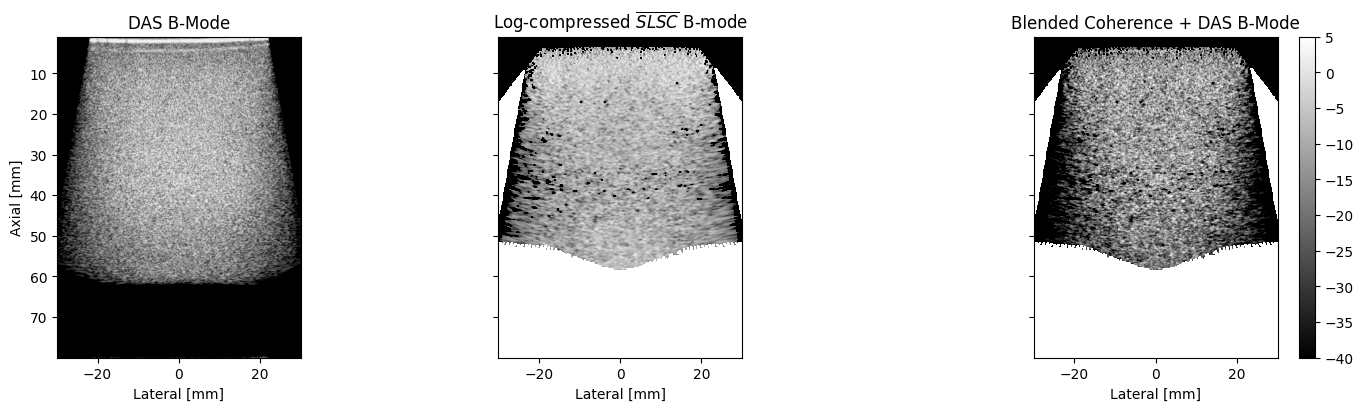

In [21]:
mask = np.array(np.mean(locpeak[:,:,:10], axis=-1), copy=True).T
mask[mask<0] = 0

blend = env[::dsfz,::dsfx] * mask


fig, axes = plt.subplots(1,3, sharey=True)
fig.set_layout_engine("constrained")
fig.set_size_inches(14, 4)

ax=axes[0]
logged = 20*np.log10(env/np.nanpercentile(env, 99) + 1E-60)
ax.imshow(logged, cmap='gray', vmin=-40, vmax=5, extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("DAS B-Mode")

ax=axes[1]
logged = 20*np.log10(mask/np.nanpercentile(mask, 99) + 1E-60)
ax.imshow(logged, cmap='gray', vmin=-40, vmax=5, extent=ex_axlat)
ax.set_xlabel("Lateral [mm]")
ax.set_title("Log-compressed $\\overline{SLSC}$ B-mode")

ax=axes[2]
logged = 20*np.log10(blend/np.nanpercentile(blend, 99) + 1E-60)
im = ax.imshow(logged, cmap='gray', vmin=-40, vmax=5, extent=ex_axlat)
ax.set_xlabel("Lateral [mm]")
ax.set_title("Blended Coherence + DAS B-Mode")
plt.colorbar(im, ax=ax)
plt.show()

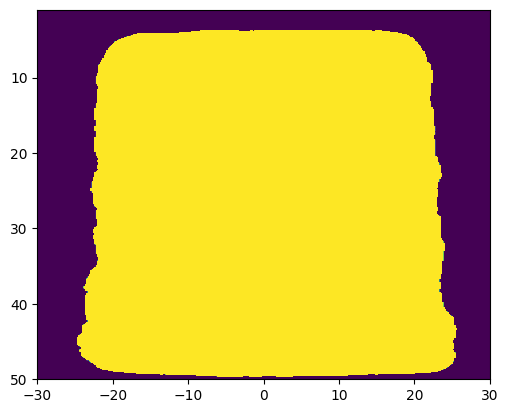

In [11]:
from scipy.signal import convolve2d
nkern = 20


smooth = convolve2d(np.nan_to_num(mask), (2/3)*np.ones((nkern,(3*nkern)//2))/nkern**2)

plt.figure()
plt.imshow(smooth>0.025, vmin=0, vmax=0.025, extent=ex_axlat, )
plt.show()